# Workflow
1. Checkout Data
2. Data Preprocessing & Feature Engineering
3. Model Building
4. Model Tuning

## 1. Checkout Data
- Target feature is already an integer
- Imbalanced dataset with 3-times more non-spam than spam e-mails
- Every e-mail starts with "Subject: " -> no information here -> can be removed
- Several duplicate rows -> delete

In [18]:
#Installing and importing packages
import sys
import nltk
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

                                                 text  spam
0   Subject: naturally irresistible your corporate...     1
1   Subject: the stock trading gunslinger  fanny i...     1
2   Subject: unbelievable new homes made easy  im ...     1
3   Subject: 4 color printing special  request add...     1
4   Subject: do not have money , get software cds ...     1
5   Subject: great nnews  hello , welcome to medzo...     1
6   Subject: here ' s a hot play in motion  homela...     1
7   Subject: save your money buy getting this thin...     1
8   Subject: undeliverable : home based business f...     1
9   Subject: save your money buy getting this thin...     1
10  Subject: las vegas high rise boom  las vegas i...     1
11  Subject: save your money buy getting this thin...     1
12  Subject: brighten those teeth  get your  teeth...     1
13  Subject: wall street phenomenon reaps rewards ...     1
14  Subject: fpa notice : ebay misrepresentation o...     1
15  Subject: search engine position  be 

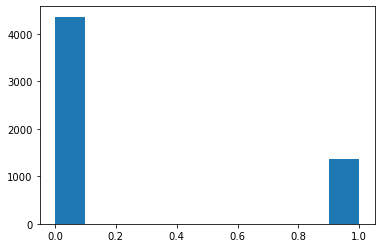

In [19]:
#Checkout dataframe
df = pd.read_csv("data/Email spam.csv")

print(df.head(n = 20))
print(df.describe())
print(df.info())
print(df.duplicated().value_counts())

#Checking how balanced data is
print(df["spam"].value_counts())

plt.hist(df["spam"])
plt.show()

## 2. Data Preprocessing & Feature engineering
- Removing "Subject: " from the start of every mail
- Deleting duplicate rows
- Adding word count, sentence count, average word and sentence length, number of punctuation and currency symbol as additional features
- Normalizing new features using MinMax Scaler
- Tokenize, remove punctuation and stem with SnowballStemmer & Creating BoW with CountVectorizer

In [20]:
#Removing duplicate rows and reset index
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace = True)
print(df.duplicated().value_counts())

False    5695
dtype: int64


In [21]:
#Removing "Subject: " from the start of every mail
df["text"] = df["text"].apply(lambda x: x.replace("Subject: ", ""))
print(df.head(n = 15))

                                                 text  spam
0   naturally irresistible your corporate identity...     1
1   the stock trading gunslinger  fanny is merrill...     1
2   unbelievable new homes made easy  im wanting t...     1
3   4 color printing special  request additional i...     1
4   do not have money , get software cds from here...     1
5   great nnews  hello , welcome to medzonline sh ...     1
6   here ' s a hot play in motion  homeland securi...     1
7   save your money buy getting this thing here  y...     1
8   undeliverable : home based business for grownu...     1
9   save your money buy getting this thing here  y...     1
10  las vegas high rise boom  las vegas is fast be...     1
11  save your money buy getting this thing here  y...     1
12  brighten those teeth  get your  teeth bright w...     1
13  wall street phenomenon reaps rewards  small - ...     1
14  fpa notice : ebay misrepresentation of identit...     1


In [22]:
#Lower casing text
df["text"] = df["text"].apply(lambda x: x.lower())

In [23]:
#Function to count words 
def word_count(text):
    only_words = text.translate(str.maketrans('', '', string.punctuation))
    return len(only_words.split())

#Function to count sentences
def sent_count(text):
    return len(nltk.sent_tokenize(text))

#Function to calculate average word length
def avg_word_length(text):
    only_words = text.translate(str.maketrans('', '', string.punctuation))
    return len(only_words)/len(only_words.split())

#Function to calculate average sentence length
def avg_sent_length(text):
    return len(text.split())/len(nltk.sent_tokenize(text))

#Function to count punctuation:
def punc_count(text):
    count = 0
    for i in range(0, len(text)):   
        if text[i] in string.punctuation:  
            count = count + 1
    return count

#Function to count common currency symbols:
def currency_count(text):
    count = 0
    for i in range(0, len(text)):   
        if text[i] in ["$", "€", "£"]:  
            count = count + 1
    return count

df["word_count"] = df["text"].apply(word_count)
df["sent_count"] = df["text"].apply(sent_count)
df["avg_word_length"] = df["text"].apply(avg_word_length)
df["avg_sent_length"] = df["text"].apply(avg_sent_length)
df["punc_count"] = df["text"].apply(punc_count)
df["currency_count"] = df["text"].apply(currency_count)

      avg_sent_length  avg_word_length  currency_count  punc_count  \
spam                                                                 
0            23.37884         5.981371        0.361914   90.785302   
1            17.37093         6.074463        1.638889   59.679825   

      sent_count  word_count  
spam                          
0      16.097065  254.467992  
1      15.206871  205.991959  


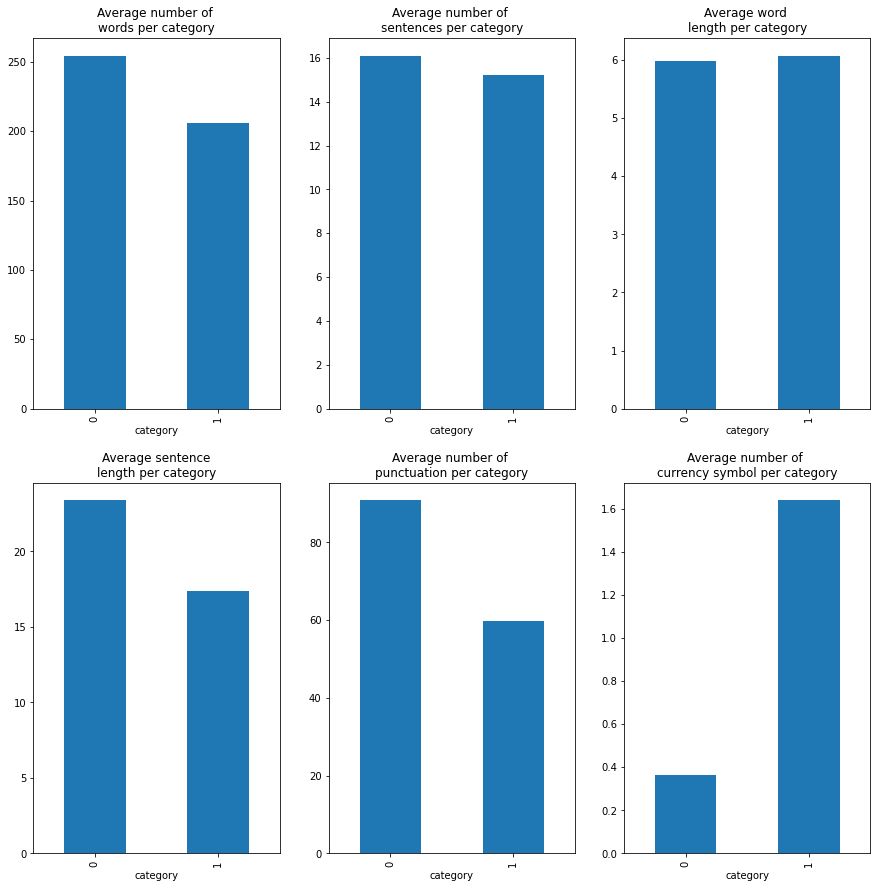

In [24]:
#Checking if mean of new features differs between the two categories
#-> Spam mails seem to contain less words on average
#-> Average word length is approximately the same in both categories
#-> Spam mails contain less punctuation
#-> Spam mails contain more currency symbols

print(pd.pivot_table(df, index = "spam", values = ["word_count", "sent_count", "avg_word_length", 
                                             "avg_sent_length", "punc_count", "currency_count"]))

%matplotlib inline
word_count = df.groupby("spam")["word_count"].mean()
sent_count = df.groupby("spam")["sent_count"].mean()
avg_word_length = df.groupby("spam")["avg_word_length"].mean()
avg_sent_length = df.groupby("spam")["avg_sent_length"].mean()
punc_count = df.groupby("spam")["punc_count"].mean()
currency_count = df.groupby("spam")["currency_count"].mean()

fig = plt.figure(figsize = (15, 15))
plt.subplot(2, 3, 1)
word_count.plot(kind = "bar", title = "Average number of \nwords per category", xlabel = "category",)

plt.subplot(2, 3, 2)
sent_count.plot(kind = "bar", title = "Average number of \nsentences per category", xlabel = "category",)

plt.subplot(2, 3, 3)
avg_word_length.plot(kind = "bar", title = "Average word \nlength per category", xlabel = "category",)

plt.subplot(2, 3, 4)
avg_sent_length.plot(kind = "bar", title = "Average sentence\nlength per category", xlabel = "category",)

plt.subplot(2, 3, 5)
punc_count.plot(kind = "bar", title = "Average number of \npunctuation per category", xlabel = "category",)

plt.subplot(2, 3, 6)
currency_count.plot(kind = "bar", title = "Average number of \ncurrency symbol per category", xlabel = "category",)
plt.show()

avg_sent_length       AxesSubplot(0.125,0.125;0.110714x0.755)
avg_word_length    AxesSubplot(0.257857,0.125;0.110714x0.755)
currency_count     AxesSubplot(0.390714,0.125;0.110714x0.755)
punc_count         AxesSubplot(0.523571,0.125;0.110714x0.755)
sent_count         AxesSubplot(0.656429,0.125;0.110714x0.755)
word_count         AxesSubplot(0.789286,0.125;0.110714x0.755)
dtype: object

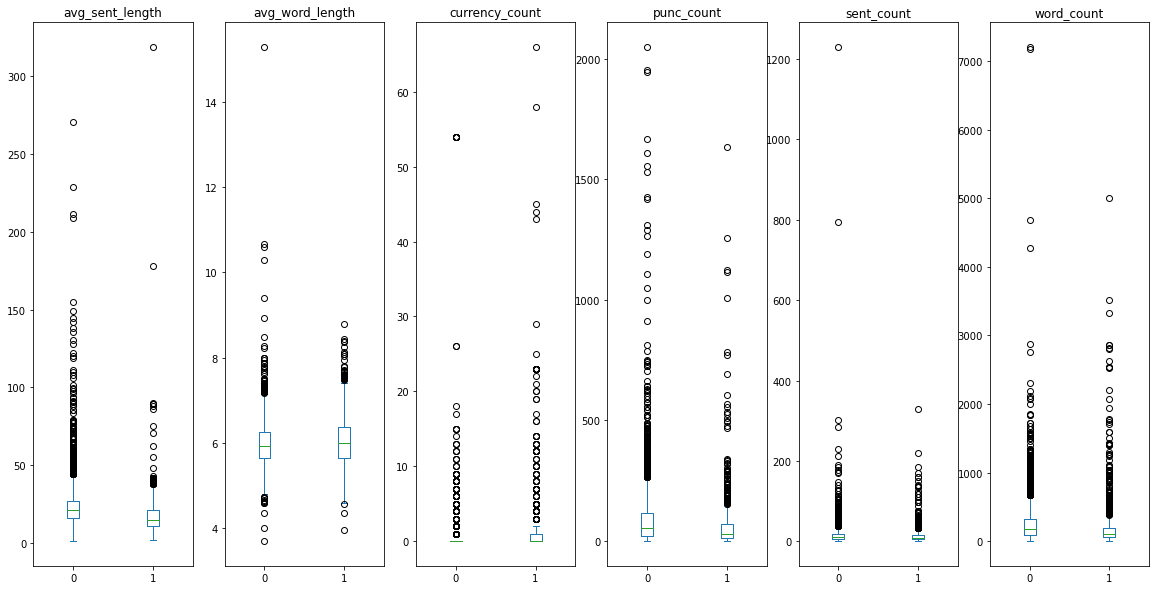

In [25]:
#Checking for outliers
df.plot(column = ["word_count", "sent_count", "avg_word_length", "avg_sent_length", "punc_count", "currency_count"], 
        by = "spam", kind = "box", subplots =True, figsize = (20, 10))

array([[<AxesSubplot:title={'center':'word_count'}>,
        <AxesSubplot:title={'center':'sent_count'}>],
       [<AxesSubplot:title={'center':'avg_word_length'}>,
        <AxesSubplot:title={'center':'avg_sent_length'}>],
       [<AxesSubplot:title={'center':'punc_count'}>,
        <AxesSubplot:title={'center':'currency_count'}>]], dtype=object)

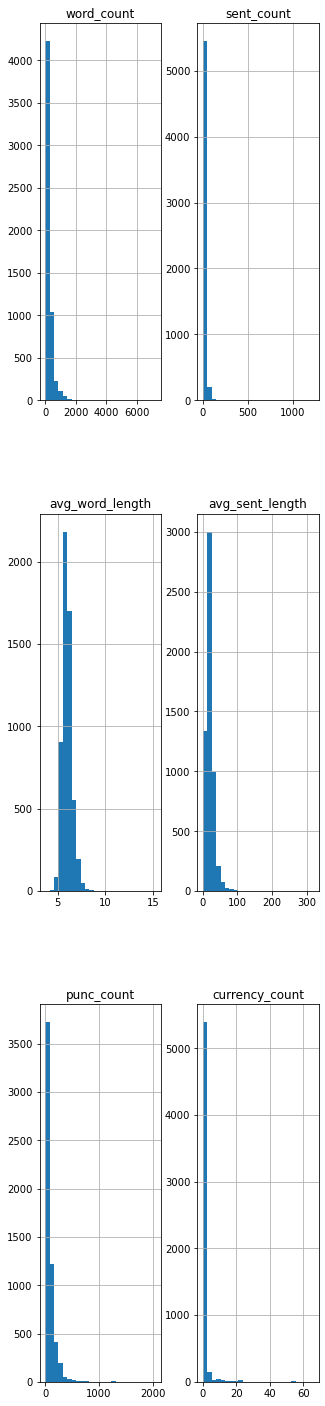

In [26]:
#Distribution of new features
df.hist(column = ["word_count", "sent_count", "avg_word_length", "avg_sent_length", "punc_count", "currency_count"], 
        figsize = (5, 25), bins = 25)

In [27]:
#Normalization of new features using MinMax Scaler
#StandardScaler would assume our data is normally distributed
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['word_count', 'sent_count', 'avg_word_length', 'avg_sent_length', 
    'punc_count', 'currency_count']] = scaler.fit_transform(df[['word_count', 'sent_count', 
                                                                'avg_word_length', 'avg_sent_length', 'punc_count', 'currency_count']])

avg_sent_length       AxesSubplot(0.125,0.125;0.110714x0.755)
avg_word_length    AxesSubplot(0.257857,0.125;0.110714x0.755)
currency_count     AxesSubplot(0.390714,0.125;0.110714x0.755)
punc_count         AxesSubplot(0.523571,0.125;0.110714x0.755)
sent_count         AxesSubplot(0.656429,0.125;0.110714x0.755)
word_count         AxesSubplot(0.789286,0.125;0.110714x0.755)
dtype: object

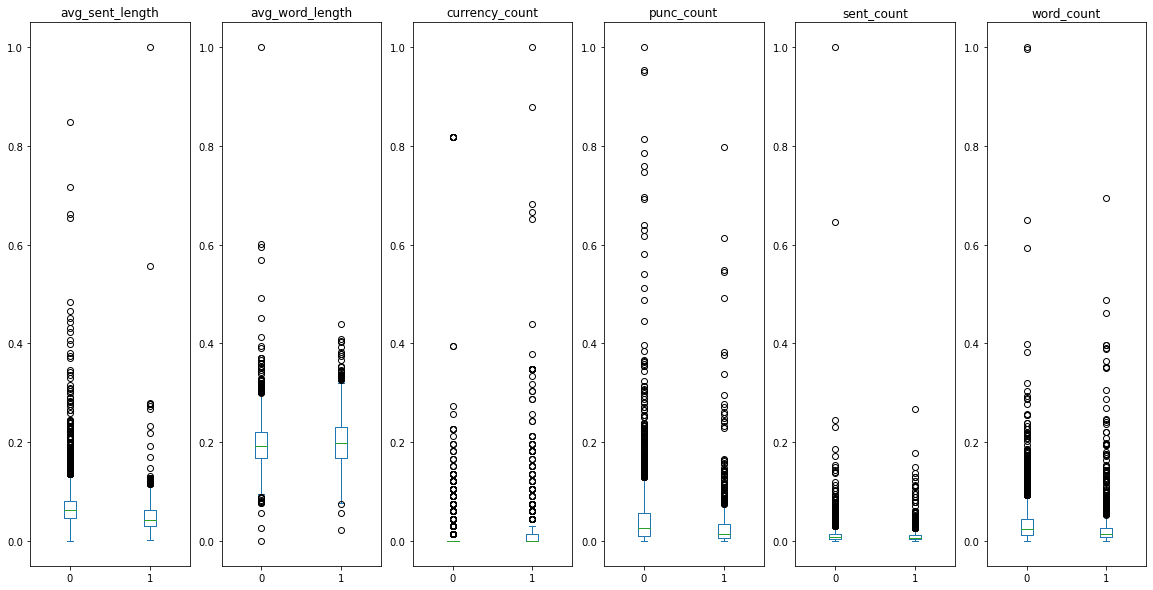

In [28]:
#Boxplots after normalization
df.plot(column = ["word_count", "sent_count", "avg_word_length", "avg_sent_length", "punc_count", "currency_count"], 
        by = "spam", kind = "box", subplots =True, figsize = (20, 10))

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

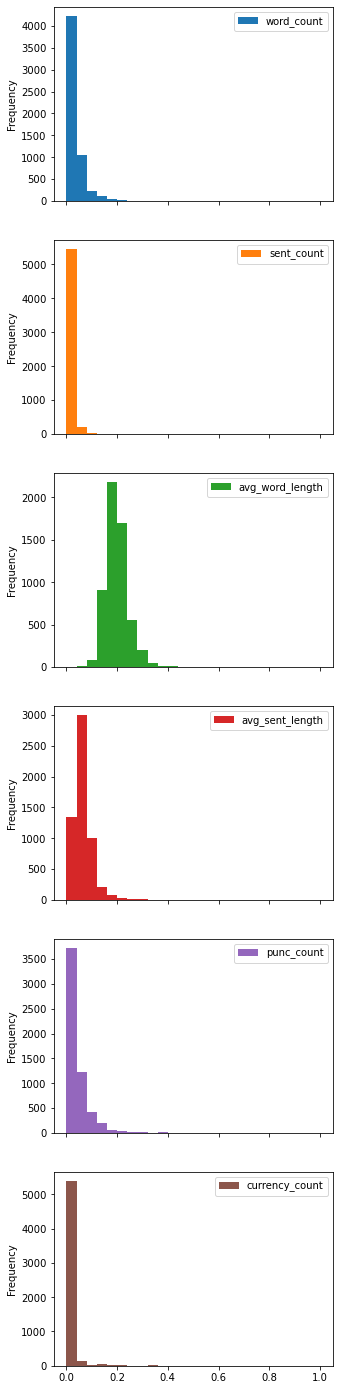

In [29]:
#Distribution after Normalization
df.plot.hist(column = ["word_count", "sent_count", "avg_word_length", "avg_sent_length", "punc_count", "currency_count"], 
        subplots =True, figsize = (5, 25), bins = 25)

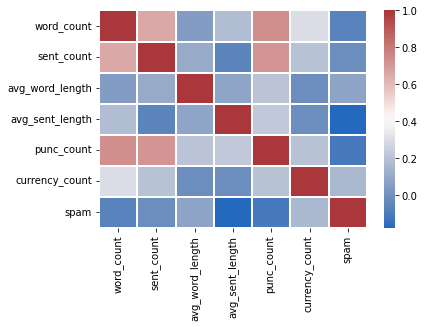

                 word_count  sent_count  avg_word_length  avg_sent_length  \
word_count         1.000000    0.654658         0.046580         0.179128   
sent_count         0.654658    1.000000         0.104989        -0.058323   
avg_word_length    0.046580    0.104989         1.000000         0.080209   
avg_sent_length    0.179128   -0.058323         0.080209         1.000000   
punc_count         0.732435    0.710056         0.204818         0.225608   
currency_count     0.299216    0.198043        -0.015212        -0.014365   
spam              -0.064606   -0.014270         0.075109        -0.178664   

                 punc_count  currency_count      spam  
word_count         0.732435        0.299216 -0.064606  
sent_count         0.710056        0.198043 -0.014270  
avg_word_length    0.204818       -0.015212  0.075109  
avg_sent_length    0.225608       -0.014365 -0.178664  
punc_count         1.000000        0.196701 -0.107545  
currency_count     0.196701        1.000000  0.

In [30]:
#Correlation matrix 
#Amount of punctuation is correlated with word and sentence length -> Maybe combine eg PCA
#Number of sentences is correlated with amount of words -> Maybe combine g PCA
#Spam category is negatively correlated with word count, sentence count, average sentence length and punctuation count

sns.heatmap(df[["word_count", "sent_count", "avg_word_length", "avg_sent_length", 
                "punc_count", "currency_count", "spam"]].corr(), cmap = "vlag", linewidths = 0.2)
plt.show()

print(df[["word_count", "sent_count", "avg_word_length", "avg_sent_length", 
                "punc_count", "currency_count", "spam"]].corr())

In [31]:
#Define function to tokenize and stem text
#Tokenization by word and removing digits and punctuation
#Using more agressive Snowball Stemmer instead of Porter Stemmer 
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

stemmer = SnowballStemmer("english")
stopwords = ", ".join(stopwords.words('english'))
def tokenize_stem(text):
    tokens = [word for word in nltk.word_tokenize(re.sub("[^a-zA-Z]", " ", text.lower())) 
          if word not in stopwords]
    stems = " ".join([stemmer.stem(token) for token in tokens])
    return stems

df["stems"] = df["text"].apply(lambda x: tokenize_stem(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lady\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
#Rename columns before vectorizing text

df = df.rename(columns={'text': 'text_raw', 'spam': 'spam_label', "stems": "text_stems"})
df.columns

Index(['text_raw', 'spam_label', 'word_count', 'sent_count', 'avg_word_length',
       'avg_sent_length', 'punc_count', 'currency_count', 'text_stems'],
      dtype='object')

In [33]:
#Bow CountVectorizer() instead of TfidfVectorizer() 
#CountVectorizer returns sparse matrix, which is converted to dense matrix and concatenated to df
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word', min_df = 5)
bow = count_vectorizer.fit_transform(df['text_stems'])
bow_df = pd.DataFrame(bow.todense(), columns = count_vectorizer.get_feature_names())
df = pd.concat([df, bow_df], axis = 1)

d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 3. Model Building
- train test split
- undersampling majority class in train data
- Baseline Performance with default paramteter for the following algorithms: 
- MultinomialNB
- Decision Tree
- SVM
- Logistic Regression
- KNN
- Random Forest

In [34]:
#Stratify split to maintain proportion of spam and non spam emails in test data
#Keeping multicolinear features (word_count, sent_count, punc_count) for now --> might lead to overfit but have to experiment with it later
import sklearn
from sklearn.model_selection import train_test_split

X = df.drop(["text_raw", "spam_label", "text_stems"], axis = 1)
y = df["spam_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=int64), array([4327, 1368], dtype=int64))
(array([0, 1], dtype=int64), array([3462, 1094], dtype=int64))
(array([0, 1], dtype=int64), array([865, 274], dtype=int64))


In [35]:
#Undersampling training data, due to imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 0)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([3462, 1094], dtype=int64))
(array([0, 1], dtype=int64), array([1094, 1094], dtype=int64))


In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [37]:
#MultinomialNB
mnb = MultinomialNB()
cv = cross_val_score(mnb, X_train_res, y_train_res, cv = 5)
print(cv)
print(cv.mean())

[0.99086758 0.98630137 0.98173516 0.99084668 0.99084668]
0.988119494686687


In [38]:
#Logistic Regression
lr = LogisticRegression()
cv = cross_val_score(lr, X_train_res, y_train_res, cv = 5)
print(cv)
print(cv.mean())

[0.99086758 0.96118721 0.97716895 0.9771167  0.9771167 ]
0.9766914307806444


In [39]:
#Decision Tree
dt = DecisionTreeClassifier()
cv = cross_val_score(dt, X_train_res, y_train_res, cv = 5)
print(cv)
print(cv.mean())

[0.93378995 0.94063927 0.93607306 0.94279176 0.94736842]
0.940132493234277


In [40]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train_res, y_train_res, cv = 5)
print(cv)
print(cv.mean())

[0.88356164 0.82191781 0.88356164 0.8604119  0.83524027]
0.8569386539606908


In [41]:
rf = RandomForestClassifier()
cv = cross_val_score(rf, X_train_res, y_train_res, cv = 5)
print(cv)
print(cv.mean())

[0.97945205 0.97716895 0.98173516 0.97482838 0.97482838]
0.9776025829911287


In [42]:
svc = SVC(probability = True)
cv = cross_val_score(svc, X_train_res, y_train_res, cv = 5)
print(cv)
print(cv.mean())

[0.96118721 0.92465753 0.95205479 0.93363844 0.94965675]
0.9442389475774009


## Model Tuning
- Keeping three algorithms performing best without hyperparameter optimization (MultinomialNB, Logistic Regression, Random Forest)
- Random Search and Grid Search optimization for Logistic Regression
- Performance check of MultinomialNB, optimized LR and RF on test data
- Ensemble models to voting classifier
- Save model

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [47]:
#Random Search CV- Logistic Regression
param_grid = {"penalty": ["l1", "l2"], "C": np.logspace(-3, 3, 20), 
              "solver": ["liblinear"], "max_iter": [1000]}
lr = LogisticRegression()
clf_lr_rnd = RandomizedSearchCV(lr, param_distributions = param_grid, n_iter = 20, cv = 3, verbose = 2, n_jobs = 1)
best_clf_lr_rnd = clf_lr_rnd.fit(X_train_res, y_train_res)

print("Best score: " +str(best_clf_lr_rnd.best_score_))
print("Best parameters: " +str(best_clf_lr_rnd.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END C=6.158482110660261, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=6.158482110660261, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=6.158482110660261, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.0379269019073225, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.0379269019073225, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.0379269019073225, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=1.438449888287663, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=1.438449888287663, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=1.438449888287663, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.6951927961775606, max_iter=1000, penalty=l1, solver=liblinear; total time=   

In [51]:
#GridSearch CV - Logistic Regression
param_grid = {"penalty": ["l2"], "C": np.linspace(0.01, 10, 25), 
              "solver": ["liblinear"], "max_iter": [1000]}
lr = LogisticRegression()
clf_lr_grid = GridSearchCV(lr, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = 1)
best_clf_lr_grid = clf_lr_grid.fit(X_train_res, y_train_res)

print("Best score: " +str(best_clf_lr_rnd.best_score_))
print("Best parameters: " +str(best_clf_lr_rnd.best_params_))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.42625, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.42625, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.42625, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.8425, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.8425, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.8425, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=1.25875, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=1.25875, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=1.25875, max_ite

In [52]:
#Random Search CV - Random Forest
param_grid = {"criterion": ["gini", "entropy"], "max_depth": [10, 15, 20, 25], 
             "max_features": ["sqrt", "log2"], "min_samples_leaf": [1, 3, 5, 10], "min_samples_split": [2, 5, 10]}
rf = RandomForestClassifier()
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 50, cv = 3, verbose = 2, n_jobs = 1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_res,y_train_res)

print("Best score: " +str(best_clf_rf_rnd.best_score_))
print("Best parameters: " +str(best_clf_rf_rnd.best_params_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_s

[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   1.0s
[CV] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=10, min_samples_split=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=10, min_samples_split=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=10, min_samples_split=10; total time=   0.3s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END criterion=entropy, max_de

[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=2; total time=   0.9s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.7s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.7s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.8s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   1.0s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   1.0s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   1.0s
[CV] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, 

In [55]:
#Prediction on test data
#MultinomialNB model
mnb = MultinomialNB()
mnb_clf = mnb.fit(X_train_res, y_train_res)
mnb_y_pred = mnb_clf.predict(X_test)
mnb_y_pred_proba = mnb_clf.predict_proba(X_test)

#Logistic Regression model
best_lr = LogisticRegression(solver= 'liblinear', penalty= 'l2', max_iter = 1000, C = 1.438449888287663)
best_clf_lr = best_lr.fit(X_train_res, y_train_res)
lr_y_pred = best_clf_lr.predict(X_test)
lr_y_pred_proba = best_clf_lr.predict_proba(X_test)

#Random Forest model
best_rf = RandomForestClassifier(min_samples_split = 2, min_samples_leaf = 5, max_features = 'sqrt', max_depth = 25, criterion = 'entropy')
best_clf_rf = best_rf.fit(X_train_res, y_train_res)
rf_y_pred = best_clf_rf.predict(X_test)
rf_y_pred_proba = best_clf_rf.predict_proba(X_test)

[[852  13]
 [  3 271]]
_______________
[[841  24]
 [  1 273]]
_______________
[[824  41]
 [  0 274]]


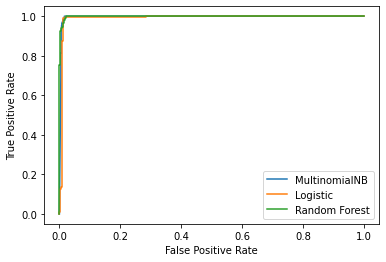

In [56]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

mnb_cf_matrix = confusion_matrix(y_test, mnb_y_pred)
print(mnb_cf_matrix)
print("_______________")
lr_cf_matrix = confusion_matrix(y_test, lr_y_pred)
print(lr_cf_matrix)
print("_______________")
rf_cf_matrix = confusion_matrix(y_test, rf_y_pred)
print(rf_cf_matrix)

#ROC Curve 
from sklearn.metrics import roc_curve

mnb_fpr, mnb_tpr, _ = roc_curve(y_test, mnb_y_pred_proba[:, 1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_pred_proba[:, 1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba[:, 1])
plt.plot(mnb_fpr, mnb_tpr, label='MultinomialNB')
plt.plot(lr_fpr, lr_tpr, label='Logistic')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [58]:
#Ensembling optimized LR and RF with MultinomialDB to voting classifier

from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators = [("mnb", mnb_clf), ('lr', best_clf_lr),('rf', best_clf_rf)], 
                              voting = 'soft')

cv = cross_val_score(voting, X_train_res, y_train_res, cv=5)
print(cv)
print(cv.mean())

[0.98858447 0.98173516 0.98173516 0.99313501 0.98855835]
0.9867496316729885


In [62]:
#Performance of voting classifier on test data
voting_clf = voting.fit(X_train_res, y_train_res)
voting_y_pred = voting_clf.predict(X_test)

voting_cf_matrix = confusion_matrix(y_test, mnb_y_pred)

print(mnb_cf_matrix)
print("_______________")
print(voting_cf_matrix)

[[852  13]
 [  3 271]]
_______________
[[852  13]
 [  3 271]]


In [66]:
#Save model
import pickle

pickle.dump(voting_clf, open("model/voting_clf.pkl", 'wb'))